## Freeze Graph

#### Load Model Reference

In [ ]:
#'''
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = './saved_models/base_models/1502/ssd7_base_epoch-30_loss-2.0457_val_loss-2.2370.h5'

#model_path = './saved_models/base_model_13_01/trained_a_base_model_1301.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

#K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

#model = load_model(model_path, custom_objects={'compute_loss': ssd_loss.compute_loss})

#'''

### Imports of the SSD Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
#from models.keras_ssd7_quantize import build_model_quantize
from models.keras_ssd7_quantize2 import build_model_quantize2
#from keras_loss_function.keras_ssd_loss import SSDLoss  #commented to test TF2.0
from keras_loss_function.keras_ssd_loss_tf2 import SSDLoss # added for TF2.0

from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_AnchorBoxes_1 import DefaultDenseQuantizeConfig
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

## imports used for pruning
import tensorflow_model_optimization as tfmot 

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

%matplotlib inline  

## loading tensorboard

#%load_ext tensorboard


### Freeze Model code - Start here

In [ ]:
# force reset ipython namespaces
%reset -f

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model
import tensorflow_model_optimization as tfmot 


# Clear any previous session.
tf.keras.backend.clear_session()

save_pb_dir = './output_saved_model_dir'

#Base model loading
#model_fname = './trained_models_local/striped_pruned_model_1601_80p.h5'

#quantized modelloading
model_fname = './trained_models_local/ssd7_base_epoch-30_loss-2.0457_val_loss-2.2370.h5'


def freeze_graph(graph, session, output, save_pb_dir='.', save_pb_name='frozen_model_base_30.pb', save_pb_as_text=False):
    with graph.as_default():
        graphdef_inf = tf.graph_util.remove_training_nodes(graph.as_graph_def())
        graphdef_frozen = tf.graph_util.convert_variables_to_constants(session, graphdef_inf, output)
        graph_io.write_graph(graphdef_frozen, save_pb_dir, save_pb_name, as_text=save_pb_as_text)
        return graphdef_frozen

# This line must be executed before loading Keras model.
tf.keras.backend.set_learning_phase(0) 

#Custom code for loading this SSD Model

# We need to create an SSDLoss object in order to pass that to the model loader.
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

#K.clear_session() # Clear previous models from memory.

#'''
model = load_model(model_fname, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

#'''

#Custom loading for Quantization models
'''
quantize_scope = tfmot.quantization.keras.quantize_scope

with quantize_scope():
    model = tf.keras.models.load_model(model_fname, custom_objects={'AnchorBoxes': AnchorBoxes, 'compute_loss': ssd_loss.compute_loss})
'''

#model = load_model(model_fname)

##Custom code for loading the model ends here

session = tf.keras.backend.get_session()

input_names = [t.op.name for t in model.inputs]
output_names = [t.op.name for t in model.outputs]

# Prints input and output nodes names, take notes of them.
print(input_names, output_names)

frozen_graph = freeze_graph(session.graph, session, [out.op.name for out in model.outputs], save_pb_dir=save_pb_dir)

### Convert to TRT code mainly for PC

In [ ]:
#code reference -> https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/index.html
# THis repo is actually made for PC TF to TF-TRT conversion

import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt_convert as trt
with tf.Session() as sess:
    # First deserialize your frozen graph:
    with tf.gfile.GFile("./output_saved_model_dir/frozen_model_base_30.pb", "rb") as f:
        frozen_graph = tf.GraphDef()
        frozen_graph.ParseFromString(f.read())
    # Now you can create a TensorRT inference graph from your
    # frozen graph:
    converter = trt.TrtGraphConverter(
        input_graph_def=frozen_graph,
        nodes_blacklist=['predictions/concat:0']) #output nodes
    trt_graph = converter.convert()
    # Import the TensorRT graph into a new graph and run:
    output_node = tf.import_graph_def(
        trt_graph,
        return_elements=['predictions/concat:0'])
    #sess.run(output_node)

### Convert to TRT code mainly for Jetson

In [ ]:
#code reference -> https://github.com/NVIDIA-AI-IOT/tf_trt_models
# THis repo is actually made for Jetson TF to TF-TRT conversion

import tensorflow.contrib.tensorrt as trt

trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

### Save the TRT Code

In [ ]:
from tensorflow.python.framework import graph_io

graph_io.write_graph(trt_graph, "./converted_trt_graph/",
                     "trt_graph_base_for_pc_ep30.pb", as_text=False)

### Ignore- Load the new model

In [ ]:
trt_model_fname = './converted_trt_graph/'


# We need to create an SSDLoss object in order to pass that to the model loader.
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

#K.clear_session() # Clear previous models from memory.

#trt_model = tf.keras.models.load_model(trt_model_fname, custom_objects={'AnchorBoxes': AnchorBoxes,'compute_loss': ssd_loss.compute_loss})
trt_model = tf.compat.v1.saved_model.loader.load(trt_model_fname)

### Ignore - Convert pb file to .h5

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

pb_model_dir = "./converted_trt_graph/"
h5_model = "./mymodel.h5"

# Loading the Tensorflow Saved Model (PB)
model = tf.keras.models.load_model(pb_model_dir)
print(model.summary())

# Saving the Model in H5 Format
tf.keras.models.save_model(model, h5_model)

# Loading the H5 Saved Model
loaded_model_from_h5 = tf.keras.models.load_model(h5_model)
print(loaded_model_from_h5.summary())

### Load converted trt pb file

In [1]:
import tensorflow as tf
from tensorflow.python.platform import gfile
#GRAPH_PB_PATH = './trained_models_local/saved_for_lab/tf_model_base_1502.pb'
#GRAPH_PB_PATH = './converted_trt_graph/trt_graph_base_for_pc_ep30.pb'
GRAPH_PB_PATH = './output_saved_model_dir/frozen_model_base_30.pb'

#GRAPH_PB_PATH = './converted_trt_graph/trt_graph_st_prg_1601_80p.pb'
#GRAPH_PB_PATH = './converted_trt_graph/trt_graph_quantized.pb'

with tf.Session() as sess:
   print("load graph")
   with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
       graph_def = tf.GraphDef()
   graph_def.ParseFromString(f.read())
   sess.graph.as_default()
   tf.import_graph_def(graph_def, name='')
   graph_nodes=[n for n in graph_def.node]
   names = []
   for t in graph_nodes:
      names.append(t.name)
    
    # print operations

   #print(names)

load graph
Instructions for updating:
Use tf.gfile.GFile.


In [2]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(graph_def, name='')

In [3]:
tf_input = tf_sess.graph.get_tensor_by_name('input_1:0')
print(tf_input)

Tensor("input_1:0", shape=(?, 300, 480, 3), dtype=float32)


In [4]:
tf_predictions = tf_sess.graph.get_tensor_by_name('predictions/concat:0')
print(tf_predictions)

Tensor("predictions/concat:0", shape=(?, ?, 18), dtype=float32)


In [5]:
IMAGE_PATH = './1478899159823020309.jpg'

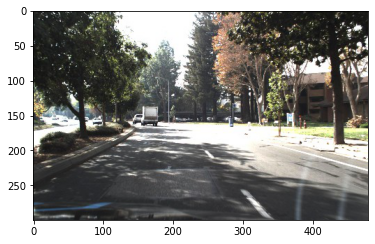

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = np.array(image.resize((480, 300)))
image = np.array(image)

In [ ]:
from tensorflow.python.keras.backend import set_session
graph = tf.get_default_graph()

with graph.as_default():
    set_session(sess)
    inputs1, predictions1 = tf_sess.run([tf_input, tf_predictions], feed_dict={
    tf_input: image_resized[None, ...]
})

In [42]:
import time

num_samples = 10

t0 = time.time()
for i in range(num_samples):
    inputs1, predictions1 = tf_sess.run([tf_input, tf_predictions], feed_dict={
    tf_input: image_resized[None, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

Average runtime: 0.002817 seconds
